# The bootstrap

Here we introduce the statistical method of bootstrapping, which can be used to obtain a sampling distribution for pretty much any descriptive statistic (most commonly the sample mean), even is sample size $n$ is too small for the central limit theorem to apply and the data distribution is grossly non-normal

"How?" I hear you ask.

Read on

### Set up Python libraries

As usual, run the code cell below to import the relevant Python libraries

In [1]:
#Set-up Python libraries - you need to run this but you don't need to change it
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as stats
import pandas 
import seaborn as sns
sns.set_theme()

## The sample as an estimate of the population

We have seen that if we draw a sample from some parent distribution, the distribution of data within the sample resembles the parent data distribution - ie the histogram of the sample looks like the histogram of the whole parent distriution.

Let's recap that using the Brexdex example

### Import the Brexdex data

[]

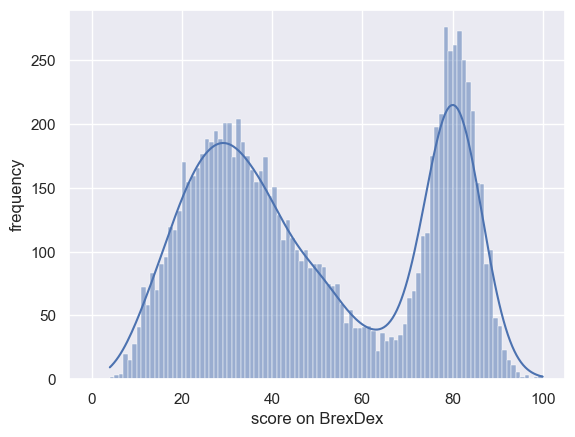

In [2]:
UKBrexdex=pandas.read_csv('https://raw.githubusercontent.com/jillxoreilly/StatsCourseBook/main/data/UKBrexdex.csv')
sns.histplot(UKBrexdex['score'], bins=range(101), kde=True)
plt.xlabel('score on BrexDex')
plt.ylabel('frequency')
plt.plot()

Let's draw a few samples from the BrexDex distribution to see how they resemble the parent distribution:

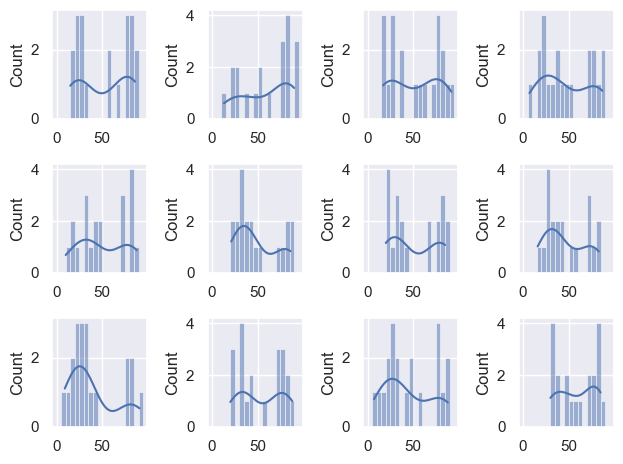

In [3]:
n=20

for i in range(12):
    plt.subplot(3,4,i+1)
    sample = np.random.choice(UKBrexdex['score'],n,replace=False)
    sns.histplot(sample, bins=range(0,100,5), kde=True)


plt.tight_layout()

The match is not too bad.

Let's go really wild and overlay the KDE plots from 100 samples (of size $n=30$) on the same graph, and add the KDE plot of the parent distribution in red

<AxesSubplot:xlabel='score', ylabel='Density'>

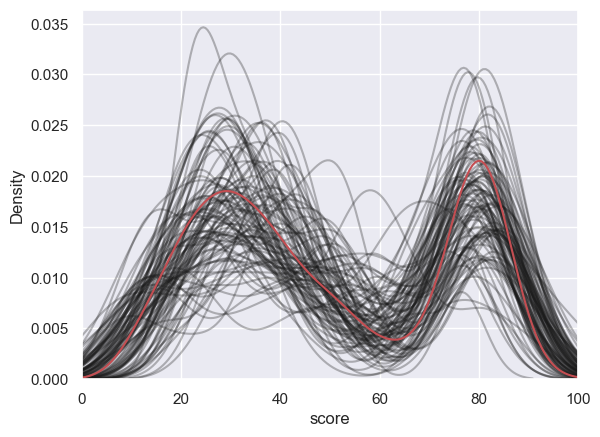

In [4]:
n=20

for i in range(100):
    sample = np.random.choice(UKBrexdex['score'],n,replace=False)
    sns.kdeplot(sample, color='k', alpha=0.3, bw_adjust=0.5) # note I manually changed the smoothing of the KDS plot - this is a bit tangential to the point of the exercise though so don't get distracted by it
    plt.xlim([0,100])
    
sns.kdeplot(UKBrexdex['score'],color='r')

The KDE plots for the samples of size $n=20$ show that the small samples approximate the parent distribution quite well

To put it another way if we were to try and generate 10,000 'simulated' responses on the Brexdex, we could do a decent job by sampling from the KDE distribution of the small $n=20$ sample

# The Bootstrap

Say I have a sample of 20 students' scores on the Brexdex.

Here is my sample:

sample mean is 54.75


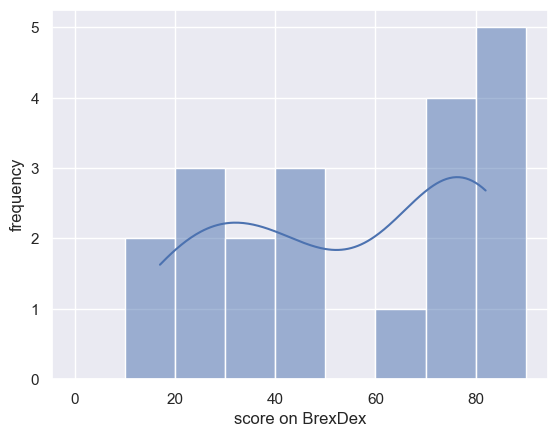

In [5]:
studentSample=pandas.read_csv('data/Brexdex_20students.csv')
sns.histplot(studentSample['score'], bins=range(0,100,10), kde=True)
plt.xlabel('score on BrexDex')
plt.ylabel('frequency')
plt.plot()

print('sample mean is ' + str(studentSample['score'].mean()))

Scores over 50 indicate an attitude against Brexit. My students' mean score is 54.75.

On the basis of this sample (and assuming the students I sampled are typical of the student population as a whole), how confident can I be that students' average Brexdex score is over 50?

the question can be <a href='https://en.wiktionary.org/wiki/operationalize'>operationalized</a> as follows:

"if I drew a large number of other samples of sie 20 from the same stuent population, what proportion of the time would the sample mean exceed 50?". If the proportion is high (say 95%) we conclude that we are confident that students are on average against Brexit.

We need the sampling distribution of the mean!


### Sampling distribution of the mean

We saw last week that the probability that if we have access to the population distribution of Brexdex scores, we can establish the sampling distribution of the mean (for sample size $n$) <a href='https://en.wiktionary.org/wiki/empirically'>empirically</a> by:
<ul>
    <li>drawing many samples of size n from the parent distribution (n=10000) 
     <li>calculating the mean for each sample
     <li>plotting them on a histogram. 
</ul>
         
This will give us the correct sampling distribution of the mean regardless of $n$.

That was a nice demonstration but it was really <i>only</i> a demonstration, as we almost never in real life have access to such a large parent distribution or the whole population. 

We are much more likely to be faced with a situation whereby we have a single sample and want to estimate the sampling distribution of the mean - that is the distribution of sample means for hundereds of other samples that <i>we will never have</i>

We saw last time that:

-- if $n$ is large, we can predict the sampling distribution of the mean as $\mathcal{N}(m,\frac{s}{\sqrt{n}})$, 

-- if $n$ is small but the data distribution is normal, we can predict the sampling distribution of the mean as $t_{n-1}(m,\frac{s}{\sqrt{n}})$

But here, $n$ is not large enough for the Central Limit Theorem to apply and the data distriubtion is not normal


### Sampling from a sample

We return to our strategy of establishing the sampling distribution of the mean <a href='https://en.wiktionary.org/wiki/empirically'>empirically</a> - namely by drawing many samples, calculating the mean of each, and plotting a histogram

However, we only have 20 datapoints to sample from, and we need to draw samples of size $n=20$ (we can't change $n$ as the spread of the sampling distribution of the mean, namely the SEM, depends on $\sqrt{n}$)

We generate these new samples by sampling <i>with replacement</i> <b>from our set of 20 students' scores</b>. This is process of sampling from a sample is sometimes called <i>resampling</i>

<img src= "https://raw.githubusercontent.com/jillxoreilly/StatsCourseBook/main/images/Minion_what.jpg" width="15%"  />


This may seem dodgy, but think of it like this - imagine our 20 students are samples from an infinite or very large population of students whom we could have surveyed, with the same distribution of Brexdex scores as our sample. We are essentially going to reverse engineer that population and sample from it (just like we did last week using the real population Brexdex distribution)

To do this reverse engineering we essentially
<ol>
    <li>fit the KDE to the 20 students' data (which, we have now established, looks a lot like the population KDE)
    <li>use that KDE to generate a huge (infinite?) simulated population of students with the same distribution of Brexdex scores as the 20 students we surveyed
    <li>draw samples of size 20 from that simulated population
        <ul><li>get the mean of each such sample
    <li>plot a histogram of the sample means
        </ul>
</ol>
        
The only thing is, it turns out that steps 1 and 2 are really well approximated by just drawing samples of $n=20$ with replacement from the original sample of 20 students - so that is what we will do!         
        
Let's try!

In [6]:
# draw one sample, the same size as the original dataset, from our 2000-students dataset
n = len(studentSample)
sample = studentSample.sample(n, replace=True)

Now let's repeat it for a lot of random (re)samples

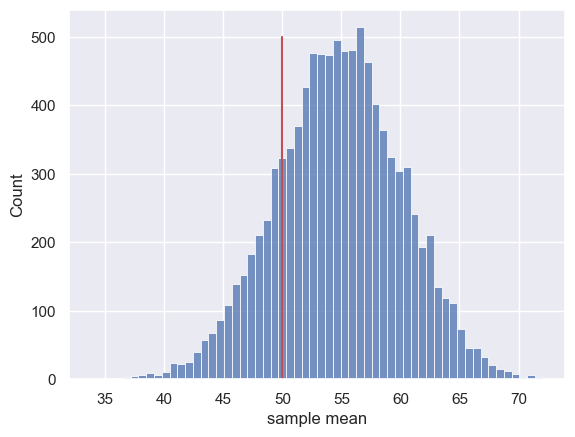

In [7]:
# make a loop to draw 10,000 samples and get the sample mean of each one
nReps = 10000
m = np.empty(nReps)

for i in range(nReps):
    sample = studentSample.sample(n, replace=True)
    m[i] = sample['score'].mean()

sns.histplot(m)
plt.plot([50,50],[0,500],'r')# add a vertical line indicating the true population mean 50
plt.xlabel('sample mean')
plt.show()

Let's work out the proportion of the time the simulated sample mean was less than 50:

In [8]:
sum(m<50)/len(m)

studentSample['score'].mean()

54.75

Hm, about 18% of the time the sample mean was actually below 50 - I don't think our dataset of 20 students gives overwhelming evidence that the student population are on average against Brexit

### The converse

Just for comparison (and this is cheating because as I said, we wouldn't normally have access to the population distribution), let's try simulating the sampling distribution of the mean by drawing samples from the UK population distribution.

We expect the distribution of sample means drawn from the parent population to be centred around the population mean score (50), but we may ask how often we get a sample mean as high as the one in our 20-students dataset (54.75):

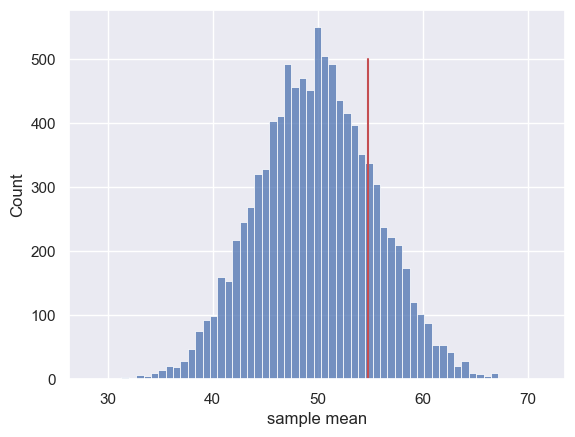

In [9]:
# make a loop to draw 10,000 samples andget the sample mean of each one
nReps = 10000
m = np.empty(nReps)

for i in range(nReps):
    sample = UKBrexdex.sample(n, replace=True)
    m[i] = sample['score'].mean()

sns.histplot(m)

plt.plot([54.75,54.75],[0,500],'r')# add a vertical line indicating the mean of our 20-students dataset
plt.xlabel('sample mean')
plt.show()

The sampling distribution is centred on the population mean of the Brexdex (50) rather than on the mean of the 20-students dataset.

However, there is a rather interesting relationship between the two sampling distributions:

The chance of getting a sample mean as high as the mean of our 20-students sample $(m=54.75)$, when sampling from the original Brexdex population, is 18.65% 

In [10]:
sum(m>studentSample['score'].mean())/len(m)

0.1929

That exactly matches the probability of getting a sample mean below the UK Brexdex mean, based on our bootstrapped sampling distribution.

Let's look at the two sampling distributions together and compare:

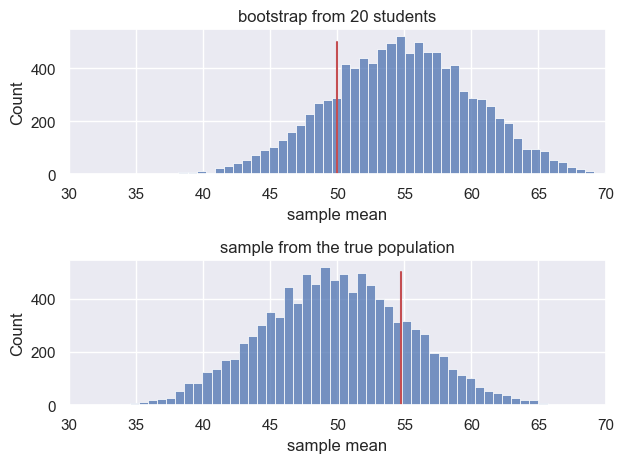

In [11]:
# bootstrap
nReps = 10000
m1 = np.empty(nReps)

for i in range(nReps):
    sample = studentSample.sample(n, replace=True)
    m1[i] = sample['score'].mean()

plt.subplot(2,1,1)
sns.histplot(m1)
plt.plot([50,50],[0,500],'r')# add a vertical line indicating the mean of our population
plt.xlabel('sample mean')
plt.xlim([30,70])
plt.title('bootstrap from 20 students')

# sample from population (UKBrexdex)
nReps = 10000
m2 = np.empty(nReps)

for i in range(nReps):
    sample = UKBrexdex.sample(n, replace=True)
    m2[i] = sample['score'].mean()

plt.subplot(2,1,2)
sns.histplot(m2)
plt.plot([54.75,54.75],[0,500],'r')# add a vertical line indicating the mean of our 20-students dataset
plt.xlabel('sample mean')
plt.xlim([30,70])
plt.title('sample from the true population')

plt.tight_layout()
plt.show()

The two sampling distributions have the same spread, such that the probability of a sample mean exceeding the mean of the 20-students dataset $(m=54.75)$, when sampling from the population (true mean $\mu=50$) is the same as the probability of a sample mean less than 50, when resampling from the 200-students dataset (sample mean = 54.75)

Ta-daaaaa! A little piece of bootstrap magic.

### Footnote

<img src="images/bootstrap.png" width="50%"  />

The term 'bootstrap' was coined by the inventor of the technique, Professor Bradley Efron, in his 1982 monograph "The Jackknife, the Bootstrap, and Other Resampling Plans". 
    
The term refers to the apparent impossibility of drawing variable samples from a dataset when the sample sie much match the sie of the dataset (the problem we tackled above) - resampling from the sample is like pulling yourself up by your own bootstraps.
    
    
Efron has the following to say about the advantages of the approach: 

<i>
"The jackknife and the bootstrap are nonparametric methods for assessing the errors in a statistical estimation problem. They provide several advantages over the traditional parametric approach: the methods are easy to describe and they apply to arbitrarily complicated situations; distribution assumptions, such as normality, are never made"
</i>    

This is a very matter of fact way of pointing out that the simple approach described here can be used to obtain the sampling distriubtion of almost anything, with very simple code, without the need for equations, assumptions or any maths at all. 

It is virtually magic.